In [2]:
import pandas as pd
from dotenv import load_dotenv
from utils import get_engine
from sqlalchemy import text
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [3]:
load_dotenv()
engine = get_engine(echo_arg=True)

In [4]:
with engine.begin() as conn:
    query = text("""SELECT * FROM "CO2_bulding_filtered_feauturs_selection"; """)
    df = pd.read_sql(query, conn)

2023-06-16 09:08:26,091 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-06-16 09:08:26,095 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-16 09:08:26,189 INFO sqlalchemy.engine.Engine select current_schema()
2023-06-16 09:08:26,196 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-16 09:08:26,251 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-06-16 09:08:26,254 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-16 09:08:26,302 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-16 09:08:26,324 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [5]:
X_cols = ['YearBuilt', 'Have_Stream_Energy', 'Have_Electricity_Energy',
       'Have_NaturalGas_Energy', 'BuildingType', 'PrimaryPropertyType',
       'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding_s_', 'LargestPropertyUseTypeGFA']
X = df[X_cols]

In [6]:
y = df['TotalGHGEmissions']

In [7]:
bool_cols = ['Have_Stream_Energy', 'Have_Electricity_Energy','Have_NaturalGas_Energy']
X[bool_cols]= X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x else 0))

/tmp/ipykernel_282503/2630812360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols]= X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x else 0))


In [8]:
X_cat = X.select_dtypes(include=[object])
X_num = X.select_dtypes(exclude=[object])

In [9]:
preparation = ColumnTransformer(transformers=[
    ('tf_cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X_cat.columns),
    ('tf_num', RobustScaler(), X_num.columns)
])

In [10]:
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

2023-06-16 09:08:27.866798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 09:08:30.288226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_tf_train = preparation.fit_transform(X_train)
X_tf_test = preparation.fit_transform(X_test)

In [12]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_tf_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

2023-06-16 09:08:34.064411: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7808      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 172,673
Trainable params: 172,673
Non-trainable params: 0
_________________________________________________________________


In [13]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]

In [14]:
NN_model.fit(X_tf_train, y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
68/68 [==============================] - 3s 16ms/step - loss: 142.7595 - mean_absolute_error: 142.7595 - val_loss: 63.3020 - val_mean_absolute_error: 63.3020
Epoch 2/500
68/68 [==============================] - 1s 9ms/step - loss: 127.9009 - mean_absolute_error: 127.9009 - val_loss: 57.4619 - val_mean_absolute_error: 57.4619
Epoch 3/500
68/68 [==============================] - 1s 9ms/step - loss: 123.0331 - mean_absolute_error: 123.0331 - val_loss: 56.9455 - val_mean_absolute_error: 56.9455
Epoch 4/500
68/68 [==============================] - 1s 9ms/step - loss: 122.5447 - mean_absolute_error: 122.5447 - val_loss: 57.4446 - val_mean_absolute_error: 57.4446
Epoch 5/500
68/68 [==============================] - 1s 9ms/step - loss: 122.1530 - mean_absolute_error: 122.1530 - val_loss: 54.9850 - val_mean_absolute_error: 54.9850
Epoch 6/500
68/68 [==============================] - 1s 13ms/step - loss: 122.6433 - mean_absolute_error: 122.6433 - val_loss: 54.3880 - val_mean_absolute

In [15]:
y_pred = NN_model.predict(X_tf_test)

22/22 [==============================] - 0s 4ms/step


In [16]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

-0.13296646035425264


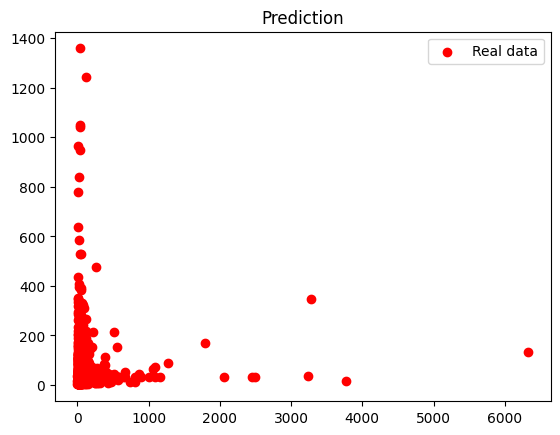

In [19]:
plt.scatter(y_test, y_pred, color = 'red', label = 'Real data')
plt.title('Prediction')
plt.legend()
plt.show()